#### 2022-04-26 LSW revision

# Novel class segmentation demo with Deep-MAC

Welcome to the Novel class segmentation (with Deep-MAC) demo --- this colab loads a Deep-MAC model and tests it interactively with user-specified boxes. Deep-MAC was only trained to detect and segment COCO classes, but generalizes well when segmenting within user-specified boxes of unseen classes.

Estimated time to run through this colab (with GPU): 10-15 minutes.
Note that the bulk of this time is in installing Tensorflow and downloading
the checkpoint then running inference for the first time.  Once you've done
all that, running on new images is very fast.

# Prerequisites

Please change runtime to GPU.

# Installation and Imports

This takes 3-4 minutes.

(we already have tfodapi)

In [1]:
# !pip install -U --pre tensorflow=="2.2.0"

# import os
# import pathlib

# # Clone the tensorflow models repository if it doesn't already exist
# if "models" in pathlib.Path.cwd().parts:
#   while "models" in pathlib.Path.cwd().parts:
#     os.chdir('..')
# elif not pathlib.Path('models').exists():
#   !git clone --depth 1 https://github.com/tensorflow/models


In [2]:
# # Install the Object Detection API
# %%bash
# cd models/research/
# protoc object_detection/protos/*.proto --python_out=.
# cp object_detection/packages/tf2/setup.py .
# python -m pip install .

In [3]:
# Donot install google-colab in host, it wont work!!!!
# !sudo pip install google-colab

### LSW-version-of-colab

In [4]:
# from google.colab import output
# from google import colab #import output
# import colab # import colab #import output

# from google import colab

In [5]:
import glob
import io
import logging
import os
import random
import warnings

import imageio
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import matplotlib
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
# from object_detection.utils import colab_utils #There's no way to run the colab frontend locally. https://stackoverflow.com/questions/65595749/cannot-install-google-colab-locally
# from object_detection.utils import colab_utils_LSW
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz_utils
from PIL import Image, ImageDraw, ImageFont
import scipy.misc
from six import BytesIO
from skimage import color
from skimage import transform
from skimage import util
from skimage.color import rgb_colors
import tensorflow as tf

%matplotlib inline

COLORS = ([rgb_colors.cyan, rgb_colors.orange, rgb_colors.pink,
           rgb_colors.purple, rgb_colors.limegreen , rgb_colors.crimson] +
          [(color) for (name, color) in color.color_dict.items()])
random.shuffle(COLORS)

logging.disable(logging.WARNING)


def read_image(path):
  """Read an image and optionally resize it for better plotting."""
  with tf.io.gfile.GFile(path, 'rb') as f:
    img = Image.open(f)
    return np.array(img, dtype=np.uint8)


def resize_for_display(image, max_height=600):
  height, width, _ = image.shape
  width = int(width * max_height / height)
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    return util.img_as_ubyte(transform.resize(image, (height, width)))


def get_mask_prediction_function(model):
  """Get single image mask prediction function using a model."""

  @tf.function
  def predict_masks(image, boxes):
    height, width, _ = image.shape.as_list()
    batch = image[tf.newaxis]
    boxes = boxes[tf.newaxis]

    detections = model(batch, boxes)
    masks = detections['detection_masks']

    return ops.reframe_box_masks_to_image_masks(masks[0], boxes[0],
                                                height, width)

  return predict_masks


def plot_image_annotations(image, boxes, masks, darken_image=0.5):
  fig, ax = plt.subplots(figsize=(16, 12))
  ax.set_axis_off()
  image = (image * darken_image).astype(np.uint8)
  ax.imshow(image)

  height, width, _ = image.shape

  num_colors = len(COLORS)
  color_index = 0

  for box, mask in zip(boxes, masks):
    ymin, xmin, ymax, xmax = box
    ymin *= height
    ymax *= height
    xmin *= width
    xmax *= width

    color = COLORS[color_index]
    color = np.array(color)
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2.5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    mask = (mask > 0.5).astype(np.float32)
    color_image = np.ones_like(image) * color[np.newaxis, np.newaxis, :]
    color_and_mask = np.concatenate(
        [color_image, mask[:, :, np.newaxis]], axis=2)

    ax.imshow(color_and_mask, alpha=0.5)

    color_index = (color_index + 1) % num_colors

  return ax

# Load Deep-MAC Model

This can take up to 5 minutes.

In [6]:
%time
print('Downloading and untarring model')
# !wget http://download.tensorflow.org/models/object_detection/tf2/20210329/deepmac_1024x1024_coco17.tar.gz
# !cp deepmac_1024x1024_coco17.tar.gz models/research/object_detection/test_data/
# !tar -xzf models/research/object_detection/test_data/deepmac_1024x1024_coco17.tar.gz
# !mv deepmac_1024x1024_coco17 models/research/object_detection/test_data/
#model_path = 'models/research/object_detection/test_data/deepmac_1024x1024_coco17/saved_model'

# only wget/tar onece
# !tar -xzf deepmac_1024x1024_coco17.tar.gz
model_path = 'deepmac_1024x1024_coco17/saved_model'

print('Loading SavedModel')
model = tf.keras.models.load_model(model_path)
prediction_function = get_mask_prediction_function(model)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
Loading SavedModel


2022-04-28 10:50:34.161350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31005 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:db:00.0, compute capability: 7.0


# Load image

In [7]:
# image_path = 'models/research/object_detection/test_images/image3.jpg'
image_path = '../models/research/object_detection/test_images/image3.jpg'
image = read_image(image_path)

# Annotate an image with one or more boxes

This model is trained on COCO categories, but we encourage you to try segmenting
anything you want!

Don't forget to hit **submit** when done.

In [9]:
display_image = resize_for_display(image)

boxes_list = []
# colab_utils.annotate([display_image], boxes_list) #這是要你給你手動描bbox用的工具 但colab不能在本機安裝! 註解掉用輸入的下面
# colab_utils_LSW.annotate([display_image], boxes_list)

# https://stackoverflow.com/questions/64659643/colab-utils-annotate-annotation-format
# #There's no way to run the colab frontend locally. https://stackoverflow.com/questions/65595749/cannot-install-google-colab-locally

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and would prefer to just use our preannotated boxes. Don't forget to uncomment.



In [10]:
boxes_list = [np.array([[0.000, 0.160, 0.362, 0.812],
                        [0.340, 0.286, 0.472, 0.619],
                        [0.437, 0.008, 0.650, 0.263],
                        [0.382, 0.003, 0.538, 0.594],
                        [0.518, 0.444, 0.625,0.554]], dtype=np.float32)]

# Visualize mask predictions

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 15 µs


2022-04-28 10:52:12.397611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-28 10:52:12.808568: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2022-04-28 10:52:12.809184: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2022-04-28 10:52:12.809870: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2022-04-28 10:52:12.810174: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2022-04-28 10:52:18.228302: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7fedcc00c9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-28 10:52:18.228346: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesl

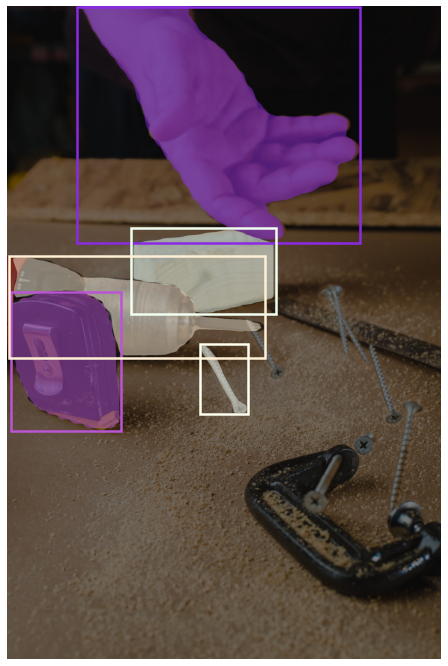

In [11]:
%time
%matplotlib inline

boxes = boxes_list[0]
masks = prediction_function(tf.convert_to_tensor(image),
                            tf.convert_to_tensor(boxes, dtype=tf.float32))
plot_image_annotations(image, boxes, masks.numpy())
plt.show()

    Args:
      annotations: list[list[dict[str, float]]]
        The input of the call back function is a list of list of objects
        corresponding to the annotations. The format of annotations is shown
        below
        [
          // stuff for image 1
          [
            // stuff for rect 1
            {x, y, w, h},
            // stuff for rect 2
            {x, y, w, h},
            ...
          ],
          // stuff for image 2
          [
            // stuff for rect 1
            {x, y, w, h},
            // stuff for rect 2
            {x, y, w, h},
            ...
          ],
          ...
        ]
    """
    x左上起點 往下
    y左上起點 往右

## fish, ferement, steak image test

### fish, ferement, steak image test

    JTest_Py_code/MatplotMouseClickPaintBrush/new_test ▶ py matplotlib_mouse_click_xy.py

    # 是[0,1]座標 要除以W H
    deepmac_test/crosi_NG_rs30_crop1024_200_0_DSC05147.jpg
        (76.52164502164504, 80.95454545454527), (478.2532467532468, 459.1363636363635)
        [156.8, 162.6, 368.81, 342.77] 
        [575.1, 549.1, 964.48, 930.13] 
        [630.9, 690.2, 902.75, 821.3] 
            [76.54/1024, 80.95/1024, 478.25/1024, 459.13/1024],
                                [134.8/1024, 155.6/1024, 368.81/1024, 382.77/1024],
                                [550.1/1024, 570.1/1024, 930.48/1024, 960.13/1024],
                                [670.9/1024, 630.2/1024, 820.75/1024, 910.3/1024],
                                
    deepmac_test/toast_NG_ps_rs28_crop1024_340_0_DSC04186.jpg
    [24.42, 188.44, 341.478, 727.93] (X -> Y) 交換
    [(22.902058465686764, 195.05431587254634), (344.8066324685147, 727.7457761994015)]  
    [(105.20322580645163, 242.09548387096788), (311.3245161290323, 697.9406451612904)]

    boxes_list = [np.array([[],
                            [],
                           ], dtype=np.float32)]

2022-04-28 11:03:55.476592: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2022-04-28 11:03:55.476636: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2022-04-28 11:03:55.477136: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.
2022-04-28 11:03:55.477149: W tensorflow/core/grappler/optimizers/meta_optimizer.cc:146] TF_ENABLE_AUTO_MIXED_PRECISION has no effect.


Inference done...


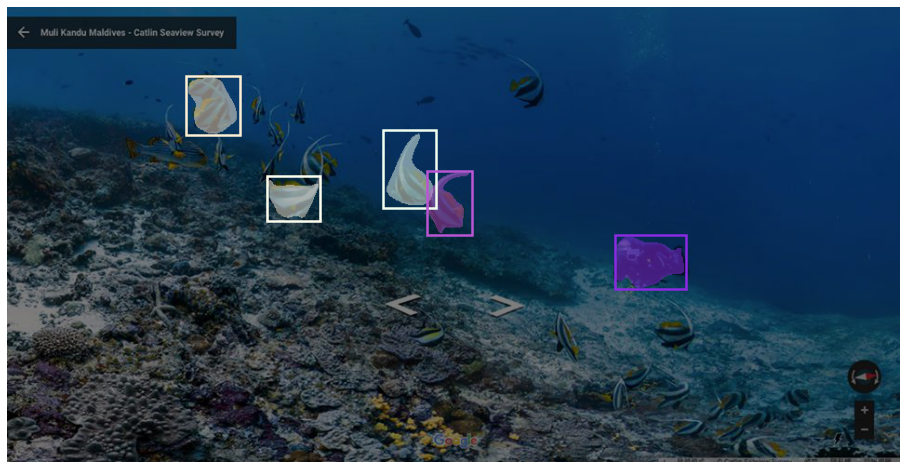

CPU times: user 16.1 s, sys: 215 ms, total: 16.3 s
Wall time: 16.2 s


In [18]:
%%time

#image_path = '../models/research/object_detection/test_images/image3.jpg'
image_path = "/home/u3148947/data/deepmac_test/toast_NG_ps_rs28_crop1024_340_0_DSC04186.jpg"
image_path = "/home/u3148947/data/deepmac_test/牛排_002.jpeg"
image_path = "/home/u3148947/data/deepmac_test/file_6216e7c231e79刮傷.png"
image_path = "/home/u3148947/data/deepmac_test/fp00958_20070419墾丁Chlorurus_sordidus白斑鸚哥魚.jpg"
image_path = "/home/u3148947/data/deepmac_test/大堡礁_001.jpg"

image = read_image(image_path)


# image_path = "/home/u3148947/data/deepmac_test/大堡礁_001.jpg"
boxes_list = [np.array([
    [ 0.5 , 0.68 , 0.62 , 0.76 ], 
    [ 0.27 , 0.42 , 0.44 , 0.48 ],
    [ 0.36 , 0.47 , 0.5 , 0.52 ],
    [ 0.15 , 0.2 , 0.28 , 0.26 ],
    [ 0.37 , 0.29 , 0.47 , 0.35 ],
                       ], dtype=np.float32)]


#"/home/u3148947/data/deepmac_test/fp00958_20070419墾丁Chlorurus_sordidus白斑鸚哥魚.jpg"
# boxes_list = [np.array([[0.34 , 0.19, 0.68 , 0.81 ],
#                        ], dtype=np.float32)]

# "/home/u3148947/data/deepmac_test/file_6216e794a30d8刮傷.jpeg"
# boxes_list = [np.array([[0.42 , 0.86, 0.52 , 0.94],
#                        ], dtype=np.float32)]


#"/home/u3148947/data/deepmac_test/牛排_002.jpeg"
# boxes_list = [np.array([[0.04687584005376344 , 0.3, 0.565 , 0.73],
#                         [0.5896715389784947 , 0.4040278477822581, 0.8769833669354838 , 0.5840278477822581],
#                         [0.46149949596774187 , 0.21112462197580648,0.7711769153225806 , 0.41112462197580646],
#                         [0.5053704637096774 , 0.6130601058467742,0.9096715389784945 , 0.8078988155241936],
#                        ], dtype=np.float32)]


#deepmac_test/ctoast_NG_ps_rs28_crop1024_340_0_DSC04186.jpg
# boxes_list = [np.array([[180.54/945, 20.95/1024, 727.25/945, 341.13/1024],
#                         [240/945, 102/1024, 697/945, 311/1024],
#                        ], dtype=np.float32)]
# boxes_list = [np.array([[0.20305, 0.024673, 0.7679235364396655, 0.3337052671370968],
#                         [240/945, 102/1024, 697/945, 311/1024],
#                         [0.20445263696876617 , 0.6762859122983871, 0.774215395118621 , 0.9808020413306452],
#                        ], dtype=np.float32)]


#deepmac_test/crosi_NG_rs30_crop1024_200_0_DSC05147.jpg
# boxes_list = [np.array([[76.54/1024, 80.95/1024, 478.25/1024, 459.13/1024],
#                         [134.8/1024, 155.6/1024, 368.81/1024, 382.77/1024],
#                         [550.1/1024, 570.1/1024, 930.48/1024, 960.13/1024],
#                         [670.9/1024, 630.2/1024, 820.75/1024, 910.3/1024],
#                        ], dtype=np.float32)]



# %matplotlib inline # it will slow down the time.

boxes = boxes_list[0]
masks = prediction_function(tf.convert_to_tensor(image),
                            tf.convert_to_tensor(boxes, dtype=tf.float32))
print("Inference done...")
plot_image_annotations(image, boxes, masks.numpy())
plt.show()

In [ ]:
# %%time
# # %matplotlib inline # it will slow down the time.

# boxes = boxes_list[0]
# masks = prediction_function(tf.convert_to_tensor(image),
#                             tf.convert_to_tensor(boxes, dtype=tf.float32))
# print("Inference done...")
# plot_image_annotations(image, boxes, masks.numpy())
# plt.show()

### How to get the hand label points

https://stackoverflow.com/questions/52235476/jupyter-notebook-register-mouse-position-clicks-moves-on-a-displayed-image-j


In [ ]:
image_path = '../models/research/object_detection/test_images/image3.jpg'
# image = read_image(image_path)

In [ ]:
%matplotlib

matplotlib.use('TkAgg')

In [ ]:
# A separate tk window will pop-up and when you click, the x,y position will print in the notebook.
# this is remote server NO pop-up !
# %matplotlib tk

# %matplotlib
# import matplotlib

matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg



fig = plt.figure(figsize=(20,30))

img=mpimg.imread(image_path)

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

In [ ]:
import matplotlib
import cv2
matplotlib.use('TkAgg')

pil = Image.open(image_path)
im = np.array(pil)
plt.imshow(im)

pts = matplotlib.pyplot.ginput(3) #number of clicks
print(pts)